**Optimization method to solve a system of nonlinear equations**
#THis is new FOR DEPLOYMENT



In [22]:
import numpy as np
#import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

To be concrete, below is the equations to be solved for x = [x₁, x₂]:
Obviously, they are nonlinear.

 $ \frac {1}{2} $ $ \frac {\sqrt [3]{x_ {2}}}{\sqrt {x_ {1}}} $ - $ \frac {1}{2} $ =0
 $ \frac {1}{3} $ $ \frac {\sqrt {x_ {1}}}{\sqrt [3]{x_ {2}^ {2}}} $ - $ \frac {1}{3} $ =0

Obviously, they are nonlinear.
Before going on further, let’s just solve the equations using the good ol’ substitution


Hence,


which is only satisfied by x₂ = 0 or x₂ = 1. Since from the second equation we can’t
have x₂ = 0, then x₂ must be 1. Substituting back, we also get x₁ to be 1. So, the
solution we want is x* = [1, 1].


**Homotopy Method**


Definition:
**Homotopy**, in mathematics, is a way of classifying
geometric regions by studying the different types of
paths that can be drawn in the region. Two paths
with common endpoints are called homotopic if one
can be continuously deformed into the other leaving
the end points fixed and remaining within its defined
region.*



In [23]:
def F(x):
  x1, x2 = x
  return np.array([1/2 * x2**(1/3) / x1**(1/2) - 1/2,
                   1/3 * x1**(1/2) / x2**(2/3) - 1/3])

Two continuous functions from one topological space to another are called
homotopic if one can be “continuously deformed” into the other. There’s a whole
branch of mathematics called topology if you want to dive deeper into homotopy.
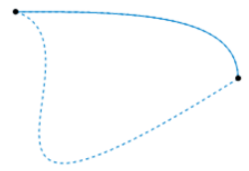


In [24]:
def H(x, lambd, x0):
  return F(x) - (1 - lambd) * F(x0)

To solve this, we build a homotopy function H(x, λ)

H(x, $ \lambda $ )=(1- $ \lambda $ )p(x)+ $ \lambda $ F(x)=0,


In [25]:
def Fprime(x):
    x1, x2 = x
    Fprime = np.zeros((2, len(x)))
    Fprime[0][0] = -1/4 * x2**( 1/3) * x1**(-3/2)
    Fprime[0][1] = 1/6 * x1**(-1/2) * x2**(-2/3)
    Fprime[1][0] = 1/6 * x2**(-2/3) * x1**(-1/2)
    Fprime[1][1] = -2/9 * x1**( 1/2) * x2**(-5/3)
    return Fprime

def derH(x):
    return Fprime(x)

The term $∂H / ∂x$ would be more efficient to be calculated numerically, so we
approximate it by setting:

 $$ \frac {\delta H}{d\lambda } $ = $ \frac {H(x,\lambda )-H(x,\lambda -\Delta \lambda )}{\Delta \lambda } $$ 
 
 All in all, $x=-J$ $$ (x,\lambda )^ {-1} $ $ \frac {H(x,\lambda )-H(x,\lambda -\Delta \lambda )}{\triangle \lambda } $$



In [26]:
def predict(lambd, lambd_prev, x0, x_init):
    delta_lambd = lambd - lambd_prev
    J = derH(x0)
    H1 = H(x0, lambd, x_init)
    H0 = H(x0, lambd_prev, x_init)
    xdot = -np.dot(np.linalg.inv(J), (H1 - H0) / delta_lambd)
    return delta_lambd, xdot

Note that using the Euler prediction, we only need the current point $(λᵢ, xᵢ)$ instead
of the last two points as in Secant prediction.

Let’s get back to our iteration process at x₀. We’ve found the candidate of $x₁$, namely
$x₁⁽⁰⁾$, from the prediction step. You might be wondering why the index $(0)$ on $x₁⁽⁰⁾$. As
you might have guessed, $x₁⁽⁰⁾$ may not satisfy $H(x, λ₁) = 0$, so we need to correct it.

***falta gráfica

To do this, we will use the Newton-Raphson method, that is, by doing the following
iterations.

 $$ x_ {1}^ {(i+1)} $ = $ x_ {1}^ {(i)} $ + $ d_ {i}, $$

with

 $$ d_ {i} $ =-J (x_ {1}^ {(i)},\lambda _ {1})^ {-1} \cdot  H( x_ {1}^ {(i)} , \lambda _ {1} )$$

for $i = 0, 1, 2, …$.


 
 


In [27]:
def correct(x1, lambd, x_init, tol, max_iter):
    H1 = H(x1, lambd, x_init)
    i = 0
    while np.linalg.norm(H1) > tol and i < max_iter:
        H1 = H(x1, lambd, x_init)
        J1 = derH(x1)
        d = -np.dot(np.linalg.inv(J1), H1)
        x1 = x1 + d
        i += 1
    return i, x1


By minimizing $ǁHǁ$, this iteration hopefully converges to some $x₁$. In this story,
iteration continues until the stopping condition $ǁHǁ < 1 × 10⁻⁵$ is reached.

If the Newton-Raphson method doesn’t converge, it means $Δλ$ is too big and we can
restart the last prediction and correction step using a smaller $Δλ$ by setting $Δλ := Δλ / 2$.

We call the iteration doesn’t converge if by the 1000-th iteration the stopping
condition is still not reached.
The convergence of the correction step indicates that we’ve found x₁ and λ₁ that
satisfies $H(x, λ) = 0$. After that, we reset $Δλ = 0.1$ and calculate $x₂$ and $λ₂ = λ₁ + Δλ$
using the same process as before. This is done iteratively until $λₙ = 1$ for some $n$, and
hence $xₙ = x*$ is the solution of $F(x) = 0$.

Below is the complete Homotopy method

In [28]:
def HomotopyMethod(x_init, lambd_step=0.1, tol=1e-5, max_iter=1000):
    # initialize values
    delta_lambd = lambd_step
    x0 = x_init
    lambd_prev = 0
    lambd = lambd_prev
    result = {'lambda':[lambd], 'x':[x0]}
    # print initial system
    print('Initial condition: λ = {:.2f}, x = {} \n'.format(lambd, x0))
    # iterate lambda
    k = 0
    while abs(lambd - 1) > np.finfo(float).eps:
        # calculate predictor using gradient
        lambd = min(lambd_prev + delta_lambd, 1)
        delta_lambd, xdot = predict(lambd, lambd_prev, x0, x_init)
        x1 = x0 + delta_lambd * xdot
 
        # calculate corrector using Newton-Raphson
        i, x1 = correct(x1, lambd, x_init, tol, max_iter)
 
        # Newton-Raphson doesn't converge
        if i == max_iter:
            delta_lambd /= 2
             # Newton-Raphson converges, update x and lambda
        else:
            delta_lambd = lambd_step
            x0 = x1
            lambd_prev = lambd
            k += 1
            result['x'].append(x1)
            result['lambda'].append(lambd)

            # print intermediary system
            print('Iteration: {} \t λ = {:.2f} \t x = {}'.format(k, lambd, x1))
 
            # if the Jacobian is singular, break the loop
            if np.isnan(np.sum(x1)):
                print('Solution not found. Try other initial value of x.')
                return None

            # print target system
    if not np.isnan(np.sum(x1)):
        print('Solution found: x =', x1)

    return result
    
##Este es un comment


Implementation
We will simulate two scenarios with different initial values x₀:
$$ x_ {0} $ =[3,17] $$
$$ x_ {0} $ =[40,3] $$

These values are completely random and the readers may try others as well.
Before going on further, let’s create two python functions below for plotting the zero
path. What’s a zero path? It’s the trajectory of points $$(x, λ)$$ for which $$H(x, λ) = 0$$



In [29]:
def plot2D(result):
    xy = np.array(result['x'])
    x = xy[:, 0]
    y = xy[:, 1]
    z = np.array(result['lambda'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    ax1.plot(z, x)
    ax1.set_title('Zero Path of H(x, λ) vs x1')
    ax1.set_ylabel(r'$x_1$')
    ax1.set_xlabel(r'$\lambda$')
    ax1.set_xlim(0, 1)

    ax2.plot(z, y)
    ax2.set_title('Zero Path of H(x, λ) vs x2')
    ax2.set_ylabel(r'$x_2$')
    ax2.set_xlabel(r'$\lambda$')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()
def plot3D(result):
    xy = np.array(result['x'])
    x = xy[:, 0]
    y = xy[:, 1]
    z = np.array(result['lambda'])
    fig = plt.figure()
    ax = Axes3D(fig)
    
    def init():
        ax.plot(x, y, z)
        ax.set_xlabel(r'$x_1$')
        ax.set_ylabel(r'$x_2$')
        ax.set_zlabel(r'$\lambda$')
        return fig

    def animate(i):
        ax.view_init(elev=15, azim=i)
        return fig

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=30, blit=True)
    anim.save('zero_path.gif', fps=30)
                                   


*Scenario 1: x₀ = [3, 17]*

In [30]:
x = [3, 17]
x_init = np.array(x)
result = HomotopyMethod(x_init)

Initial condition: λ = 0.00, x = [ 3 17] 

Iteration: 1 	 λ = 0.10 	 x = [2.08537268 8.91884867]
Iteration: 2 	 λ = 0.20 	 x = [1.60780604 5.44710791]
Iteration: 3 	 λ = 0.30 	 x = [1.33067735 3.6865263 ]
Iteration: 4 	 λ = 0.40 	 x = [1.16057914 2.68847692]
Iteration: 5 	 λ = 0.50 	 x = [1.05463161 2.07631858]
Iteration: 6 	 λ = 0.60 	 x = [0.99114286 1.67885141]
Iteration: 7 	 λ = 0.70 	 x = [0.95854539 1.41008067]
Iteration: 8 	 λ = 0.80 	 x = [0.9506931  1.22340085]
Iteration: 9 	 λ = 0.90 	 x = [0.96471009 1.09204905]
Iteration: 10 	 λ = 1.00 	 x = [1. 1.]
Solution found: x = [1. 1.]


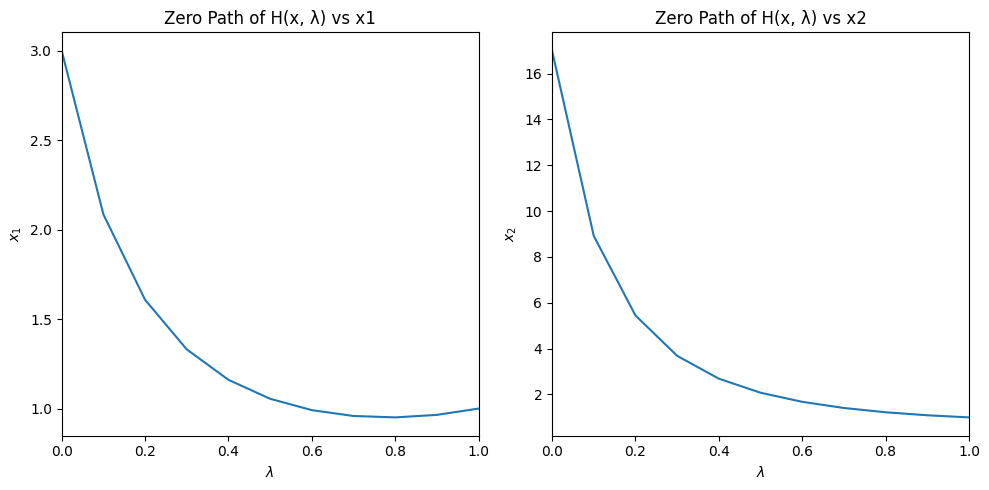

In [31]:
plot2D(result)

In [ ]:
%matplotlib notebook
plot3D(result)

<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable; using Pillow instead.


We see that the Homotopy method managed to find the solution x* = [1, 1] after 10
iterations, with each step Δλ = 0.1, a temporary solution xₙ is found. That is, the
algorithm succeeded in minimizing ǁHǁ so that ǁHǁ < 1 × 10⁻⁵ for each iteration, and
successfully running from λ = 0 to λ = 1 continuously through the zero path of H.

Scenario 2: x₀ = [40, 30]

In [ ]:
x_init = np.array([17, 30])
result = HomotopyMethod(x_init)
plot2D(result)


The Homotopy method only runs successfully for 1 iteration up to λ₁ = 0.1 with x₁ =
[-8.79, 0.56], before the Newton-Raphson method is unable to find a solution that
converges to x₂. This is because the Jacobian J is singular in the second iteration.
From this, it can be seen that the selection of the initial variable x₀ is one of the
important things to consider in solving the system of equations F(x) = 0 using the
Homotopy method.

In [ ]:
x_init = np.array([17, 30])
result = HomotopyMethod(x_init)
plot2D(result)

Conclusion
We’ve been using the Homotopy method to find a solution to a system of nonlinear
equations. The idea of the Homotopy method is to deform an initial system, which
we know the solution of, to the final system we want. The deforming process
generates a zero path of the homotopy function which may not be continuous
depending on the initial system. With this method, we find the solution of our given
system of equations to be x* = [1, 1].